In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Hyperparameters

In [76]:
TRAIN_SIZE = 0.80
BATCH_SIZE = 32
EPOCHS = 50

# Data Loading

Labels in data are integers. Define a map to interpret the labels.

In [3]:
class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
n_classes = len(class_names)

Parse the csv file and save image arrays to X, and labels to Y.

In [4]:
data_path = "../large_data/fer/fer2013.csv"
handle = open(data_path)
first_row = True
X = []
Y = []
for row in handle:
    if first_row:
        first_row = False
    else:
        row = row.split(",")
        Y.append(int(row[0]))
        X.append([int(p) for p in row[1].split()])
X = np.array(X)
Y = np.array(Y)

n = X.shape[0]
n_pixels = X.shape[1]
print("Number of images: %d" % n)
print("Number of pixels: %d" % n_pixels)

Number of images: 35887
Number of pixels: 2304


Input image arrays are flattened. Reshape to 2D, and add extra dimension for color channel (one, being it grey scale).

In [5]:
IMG_SHAPE = int(np.sqrt(n_pixels))  # 48x48 pixels
X = X.reshape((X.shape[0], IMG_SHAPE, IMG_SHAPE, 1))
X.shape

(35887, 48, 48, 1)

Check that number of integer labels is consistent with number of given classes.

In [7]:
assert(len(np.unique(Y)) == n_classes)

### Split into train and validation sets

Shuffle X and Y in unison.

In [12]:
np.random.seed(1234)
idx = np.random.permutation(n)
X_shuffled = X[idx]
Y_shuffled = Y[idx]

Split into train and test.

In [15]:
n_train = int(n*TRAIN_SIZE)
n_test = n - n_train
Xtrain = X_shuffled[:n_train]
Xtest = X_shuffled[n_train:]
Ytrain = Y_shuffled[:n_train]
Ytest = Y_shuffled[n_train:]

# Data Pipeline Preparation

Define the generators to handle the train and test data pipelines. For train, include image augmentation techniques to reduce overfitting.

In [16]:
gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

gen_test = ImageDataGenerator(rescale=1./255)

Use the generators to create the data pipelines. Shuffle train data at the beginning of each new epoch.

In [17]:
data_train = gen_train.flow(Xtrain, Ytrain,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

data_test = gen_test.flow(Xtest, Ytest,
                          batch_size=BATCH_SIZE)

## Visualize images

In [18]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(batch, n=5):
    cls = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
    n_cols = 5
    n_rows = 1 + (n - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
    axes = axes.reshape(n_rows, n_cols)
    images = batch[0][:n]
    labels = batch[1][:n]
    for i, img in enumerate(images):
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(img.reshape(IMG_SHAPE, IMG_SHAPE), cmap='gray')
        ax.set_title(cls[labels[i]])
    plt.tight_layout()
    plt.show()

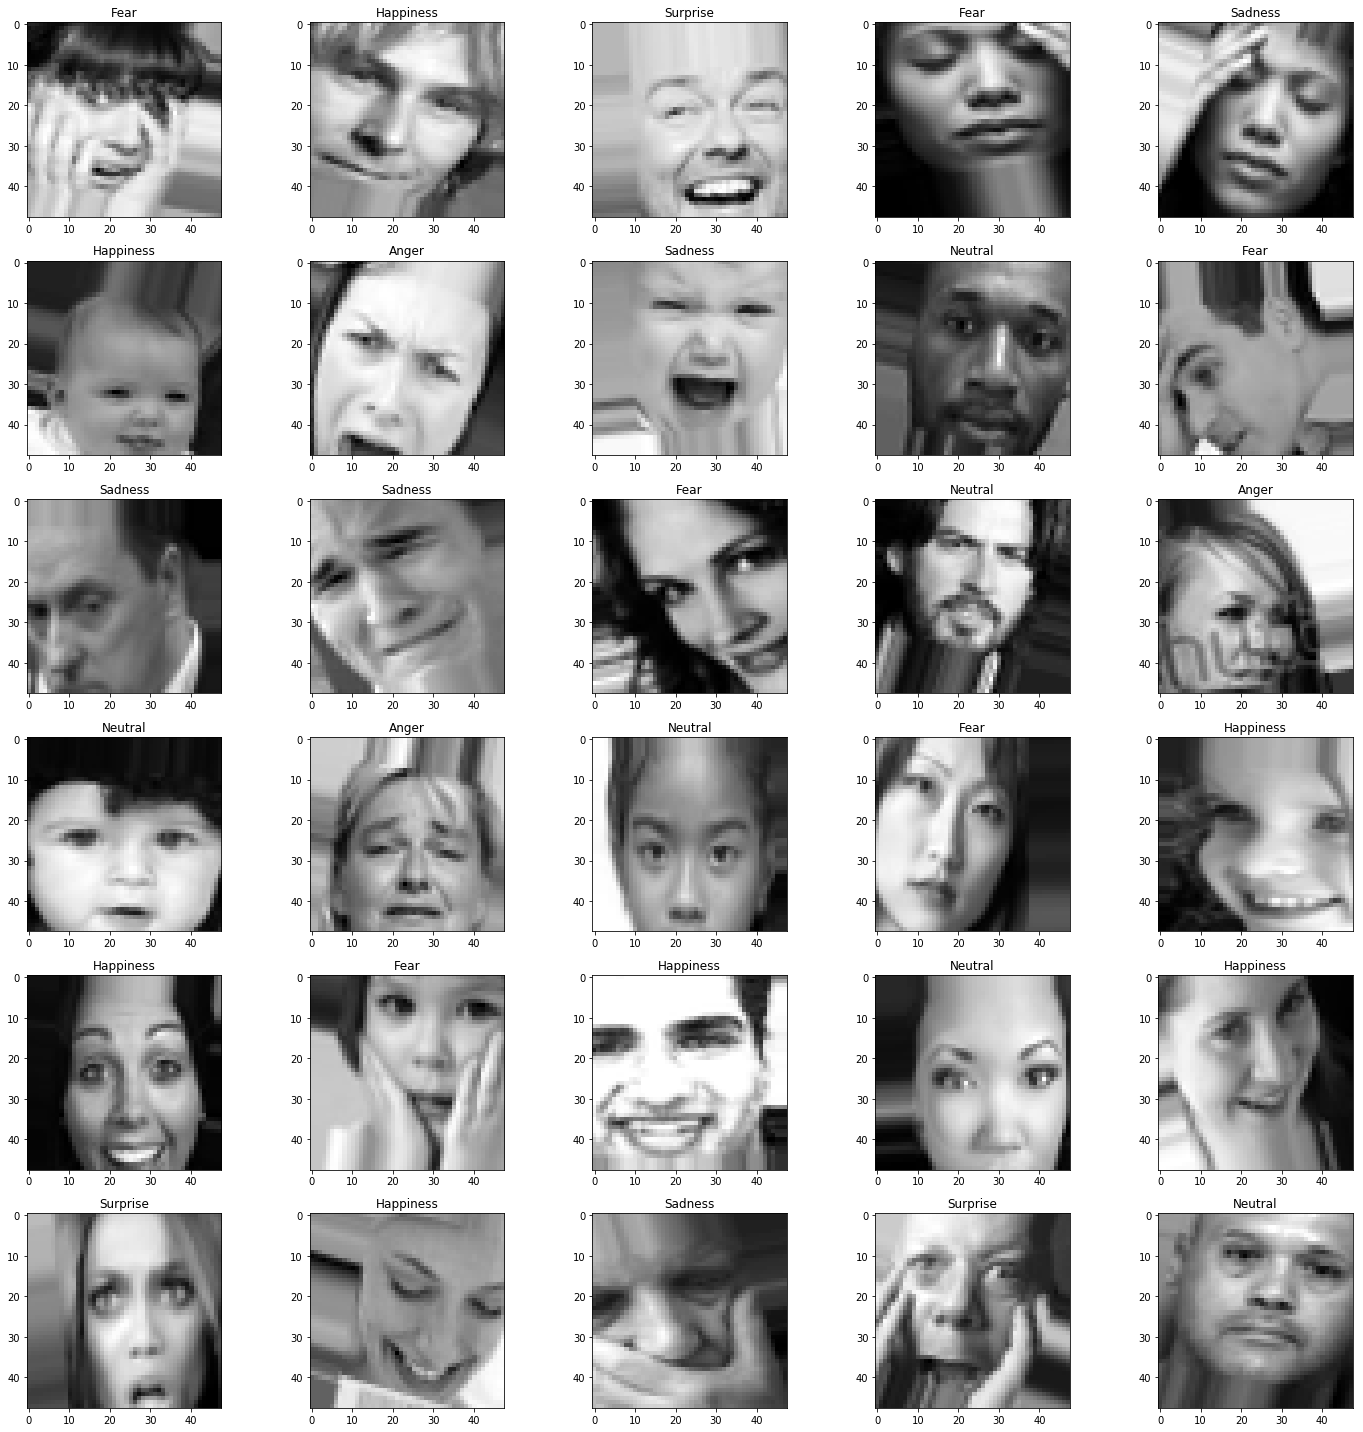

In [20]:
plotImages(next(data_train), n=30)  # Plot images from current batch

# Basic CNN model

In [80]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 1)),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 1)),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 1)),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 1)),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [82]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 8)         80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 64)         

## Train the model

### Find optimal learning rate

In [83]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [87]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 30))
history = model.fit_generator(data_train,
                              epochs=EPOCHS,
                              callbacks=[lr_schedule])

Epoch 1/50
898/898 [==============================] - 64s 72ms/step - loss: 1.8023 - accuracy: 0.2501
Epoch 2/50
898/898 [==============================] - 72s 80ms/step - loss: 1.7672 - accuracy: 0.2699
Epoch 3/50
898/898 [==============================] - 68s 76ms/step - loss: 1.7242 - accuracy: 0.2951
Epoch 4/50
898/898 [==============================] - 65s 73ms/step - loss: 1.6752 - accuracy: 0.3324
Epoch 5/50
898/898 [==============================] - 65s 72ms/step - loss: 1.6208 - accuracy: 0.3594
Epoch 6/50
898/898 [==============================] - 64s 71ms/step - loss: 1.5846 - accuracy: 0.3782
Epoch 7/50
898/898 [==============================] - 64s 71ms/step - loss: 1.5537 - accuracy: 0.3902
Epoch 8/50
898/898 [==============================] - 63s 71ms/step - loss: 1.5244 - accuracy: 0.4028
Epoch 9/50
898/898 [==============================] - 64s 71ms/step - loss: 1.5099 - accuracy: 0.4135
Epoch 10/50
898/898 [==============================] - 64s 71ms/step - loss: 1.499

[0.001, 0.1, 0, 2]

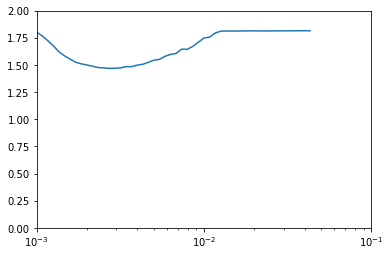

In [98]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-3, 1e-1, 0, 2])

### Train with early stopping

In [99]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [100]:
history = model.fit_generator(data_train,
                              steps_per_epoch=int(np.ceil(n_train / BATCH_SIZE)),
                              validation_data=data_test,
                              validation_steps=int(np.ceil(n_test / BATCH_SIZE)),
                              epochs=EPOCHS,
                              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
358/898 [==========>...................] - ETA: 39s - loss: 1.8119 - accuracy: 0.2502

KeyboardInterrupt: 

### Loss and accuracy graphs

In [38]:
test_loss, test_accuracy = model.evaluate(data_test, steps=int(np.ceil(n_test/BATCH_SIZE)))
print('Accuracy on test dataset:', test_accuracy)

225/225 [==============================] - 2s 9ms/step - loss: 1.2940 - accuracy: 0.5111
Accuracy on test dataset: 0.5111452


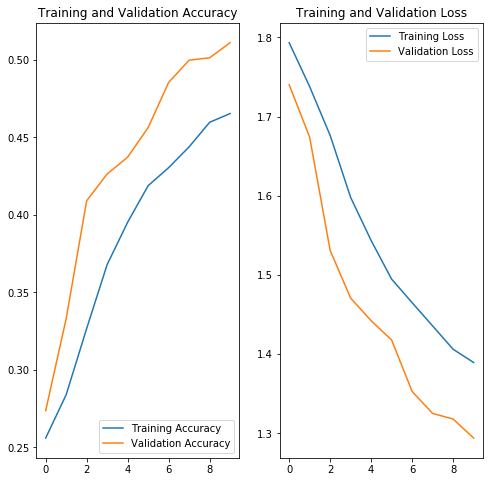

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Class: Fear
Prediction: Happiness


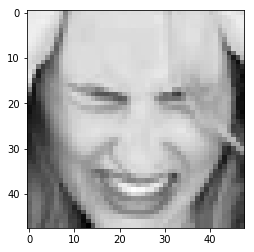

In [70]:
i_batch = np.random.choice(int(np.ceil(n_test/BATCH_SIZE)))
i_img = np.random.choice(BATCH_SIZE)

label = data_test[i_batch][1][i_img]
pred  = model.predict_classes(data_test[i_batch][0])[i_img]

plt.imshow(data_test[i_batch][0][i_img][:,:,0], cmap='gray')
print(("CORRECT" if label == pred else "WRONG") + " (class: %s, prediction: %s)" % (class_names[label], class_names[pred]))

# CNN model with transfer learning

### Import Mobilenet v2 pre-trained

We import the feature vector from Tensorflow Hub. The feature vector does not include the output layer, that we need to retrain on the specific data at hand.

In [33]:
!pip install -p -U tensorflow_hub
import tensorflow_hub as hub

In [138]:
IMG_RES = 96  # input resolution expected by the imported model
URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4"
feature_extractor = hub.KerasLayer(handle=URL,
                                   input_shape=(IMG_RES, IMG_RES, 3),
                                   trainable=False)  # note that we do want to retrain it

### Resize images and repeat preprocessing

The FER database consists of (grayscale) images of shape (48, 48, 1). Mobilenet expects images of shape (96, 96, 3). We need to resize and duplicate the single grayscale color channel into three RGB color channels of identical intensity. We use Tensorflow methods that conveniently accepts batches as input.

In [146]:
X_res = tf.image.grayscale_to_rgb(tf.image.resize(X_shuffled, size=(IMG_RES, IMG_RES)))
X_res.shape

TensorShape([35887, 96, 96, 3])

In [147]:
Xtrain_res = X_res[:n_train]
Xtest_res = X_res[n_train:]

data_train_res = gen_train.flow(Xtrain_res, Ytrain,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

data_test_res = gen_test.flow(Xtest_res, Ytest,
                          batch_size=BATCH_SIZE)

### Model with transfer learning

In [190]:
model2 = tf.keras.Sequential([
    feature_extractor,  # reused model
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              706224    
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 8967      
Total params: 715,191
Trainable params: 8,967
Non-trainable params: 706,224
_________________________________________________________________


We use early stopping to halt training when validation accuracy stops improving. We also select the weights that correspond to the best performing model.

In [192]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=10,
    restore_best_weights=True)

In [193]:
history2 = model2.fit_generator(data_train_res,
                                validation_data=data_test_res,
                                epochs=EPOCHS,
                                callbacks=[early_stopping])

Epoch 1/50
898/898 [==============================] - 358s 398ms/step - loss: 1.6116 - accuracy: 0.3757 - val_loss: 1.4859 - val_accuracy: 0.4278
Epoch 2/50
898/898 [==============================] - 373s 416ms/step - loss: 1.5191 - accuracy: 0.4153 - val_loss: 1.4627 - val_accuracy: 0.4365
Epoch 3/50
898/898 [==============================] - 366s 408ms/step - loss: 1.4920 - accuracy: 0.4291 - val_loss: 1.4568 - val_accuracy: 0.4398
Epoch 4/50
898/898 [==============================] - 372s 414ms/step - loss: 1.4819 - accuracy: 0.4295 - val_loss: 1.4399 - val_accuracy: 0.4531
Epoch 5/50
898/898 [==============================] - 369s 411ms/step - loss: 1.4753 - accuracy: 0.4359 - val_loss: 1.4346 - val_accuracy: 0.4609
Epoch 6/50
898/898 [==============================] - 364s 405ms/step - loss: 1.4689 - accuracy: 0.4380 - val_loss: 1.4334 - val_accuracy: 0.4528
Epoch 7/50
898/898 [==============================] - 379s 422ms/step - loss: 1.4563 - accuracy: 0.4415 - val_loss: 1.4258 -

### Loss and accuracy

In [194]:
test_loss, test_accuracy = model2.evaluate(data_test_res)
print('Accuracy on test dataset:', test_accuracy)

225/225 [==============================] - 18s 78ms/step - loss: 1.4415 - accuracy: 0.4531
Accuracy on test dataset: 0.453051


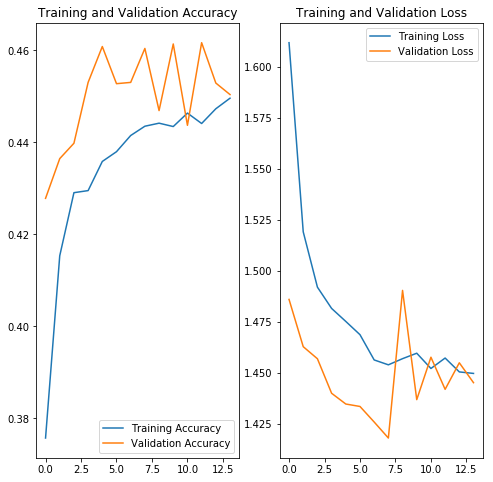

In [195]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(history2.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

CORRECT (class: Neutral, prediction: Neutral)


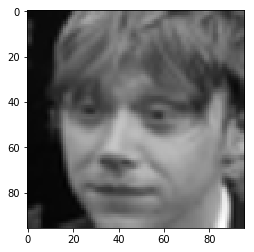

In [242]:
i_batch = np.random.choice(int(np.ceil(n_test/BATCH_SIZE)))
i_img   = np.random.choice(BATCH_SIZE)

label = data_test_res[i_batch][1][i_img]
pred  = model2.predict_classes(data_test_res[i_batch][0])[i_img]

plt.imshow(data_test_res[i_batch][0][i_img])
print(("CORRECT" if label == pred else "WRONG") + " (class: %s, prediction: %s)" % (class_names[label], class_names[pred]))

### Confusion matrix

In [225]:
import itertools

In [229]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = tf.math.reduce_max(cnf_matrix).numpy() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [246]:
pred=model2.predict_classes(Xtest_res)

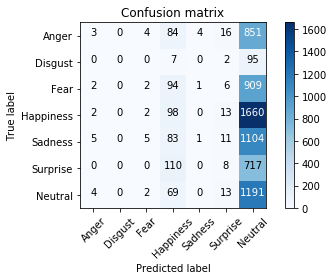

In [250]:
# Generate the confusion matrix
cnf_matrix = tf.math.confusion_matrix(labels=Ytest, predictions=pred)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

plt.show()

Class imbalance?

In [259]:
{class_names[i]:sum(Ytrain==i) for i in range(n_classes)}

{'Anger': 3991,
 'Disgust': 443,
 'Fear': 4107,
 'Happiness': 7214,
 'Sadness': 4868,
 'Surprise': 3167,
 'Neutral': 4919}

Class 'Disgust' is seriously underrepresented, and class Happiness is overrrepresented. Otherwise, there is good balance.